In [3]:
cd

/home/luxx0489


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import mne
from scipy.io import loadmat, savemat
from scipy.stats import circmean
from sklearn import decomposition
from random import sample

In [4]:
sample_size = [300,600,900,1200,1500]
ind_list = [sample(range(1500),size) for size in sample_size]

len(ind_list[0])

300

In [38]:
data_path = './jupyter_projects/StreamingEEG_exp5/'
folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_100_200Hz/"

mask_ch = np.ones(64,dtype=bool)
mask_ch[27] = False

file_handle = open(data_path +'electrode_pos.obj','rb')
pos = pickle.load(file_handle)[mask_ch,:]
file_handle.close()

ID_list = np.arange(2,18)
mask = np.ones(len(ID_list),dtype=bool)
mask[3] = False


In [10]:
# load data


sample_size = [300,600,900,1200,1500]
plv_out = np.empty((15,2,len(sample_size),4,224))
ID_list = np.arange(2,18)
mask = np.ones(len(ID_list),dtype=bool)
mask[3] = False

plv_channels = np.empty((15,2,len(sample_size),63,224))

Ref_list = ['M12','AVE']


mask_ch = np.ones(64,dtype=bool)
mask_ch[27] = False

for iSubject in range(len(ID_list[mask])):
    print(str(iSubject))
    
    for iRef in range(2):
        
        # read data
        sub_id = 'Sub' + str(ID_list[mask][iSubject])
        mat_contents = loadmat(folder_path + sub_id+'/'+sub_id+'_TMR-5_MSK_LF_'+Ref_list[iRef]
                               +'_Ref_REcleaned.mat')
        ind_list = [sample(range(1500),size) for size in sample_size]
        if iRef==0:
            data = mat_contents['Merged_Data'][mask_ch,103:103+446,:]
        else:
            data = mat_contents['Merged_Data'][:,103:103+446,:]
        nTrial = data.shape[2]

        # FFT
        x=data.transpose(2,0,1)
        xw = np.fft.rfft(np.hamming(x.shape[2])*x, axis=2)
        xw = xw/abs(xw)
        freq = np.fft.rfftfreq(x.shape[2],1/1024)

        for iSize in range(len(sample_size)):
            plv_ave = xw[ind_list[iSize],:,:].mean(0)
            plv_out[iSubject,iRef,iSize,0,:] = abs(plv_ave).mean(0)
            plv_out[iSubject,iRef,iSize,1,:] = abs(plv_ave[37,:])

            plv_channels[iSubject,iRef,iSize,:,:] = abs(plv_ave)

        # cPCA
            plv_mat=np.empty((63,xw.shape[2]),dtype=np.complex64)
            v_mat = []
            for iFreq in range(xw.shape[2]):
                csd = np.matmul(xw[ind_list[iSize],:,iFreq].T,xw[ind_list[iSize],:,iFreq].conj())
                w,v = np.linalg.eig(csd)
                v_mat.append(v)
                pc = np.matmul(v.conj().T,xw[ind_list[iSize],:,iFreq].T)
                plv = (pc/abs(pc)).mean(1)
                plv_mat[:,iFreq] = plv

            plv_out[iSubject,iRef,iSize,2,:] = abs(plv_mat[0,:])

            # concatenate and tPCA
            mix_long = np.concatenate([x[iTrial,:,:] for iTrial in ind_list[iSize]], axis=1)

            pca = decomposition.PCA(n_components=1)
            pca.fit(mix_long.T)
            pc_t = np.empty((len(ind_list[iSize]),446))
            for iTrial in range(len(ind_list[iSize])):
                pc_t[iTrial,:] = pca.transform(x[ind_list[iSize][iTrial],:,:].T).squeeze()
            xw_pc_t = np.fft.rfft(pc_t, axis=1)
            xw_pc_t = xw_pc_t/abs(xw_pc_t)
            plv_pc_t = xw_pc_t.mean(0)

            plv_out[iSubject,iRef,iSize,3,:] = abs(plv_pc_t)

plv_out_LF = plv_out
plv_channels_LF = plv_channels

0
1


KeyboardInterrupt: 

In [8]:

file_handle = open(folder_path + '/plv_LF.obj','wb')
pickle.dump(plv_out_LF, file_handle)
pickle.dump(plv_channels_LF, file_handle)
file_handle.close()

In [44]:
file_handle = open(folder_path + '/plv_LF.obj','rb')
plv_out = pickle.load(file_handle)
plv_channels = pickle.load(file_handle)
file_handle.close()

In [45]:
index_1 = np.argmin(abs(freq-98))
index_2 = np.argmin(abs(freq-60))
index_3 = np.argmin(abs(freq-80))

In [2]:
plv_n_df = pd.DataFrame(colums=['Subject','Ref','Size','Method','nPLV'])
Method_list = ['All','Single','cPCA','tPCA']
Ref_list = ['M12','Ave']

plv_n = np.empty(plv_out.shape[0:4])

for iMethod in range(4):
    for iSize in range(5):
        for iRef in range(2):
            for iSubject in range(15):
                signal = plv_out[iSubject,iRef,iSize,iMethod,index_1]
                noise = plv_out[iSubject,iRef,iSize,iMethod,index_2:index_3]
                plv_n[iSubject,iRef,iSize,iMethod] = (signal-noise.mean())/noise.std()
                plv_n_df.append({'Subject':iSubject,
                                'Ref':Ref_list[iRef],
                                'Size':sample_size[iSize],
                                'Method':Method_list[iMethod],
                                'nPLV':(signal-noise.mean())/noise.std()})

plt.figure(figsize=(12,8))
         
width = 30    
    
lgd_list=['All-channel average','Single channel (Fz)','cPCA first PC','tPCA first PC']


for i in range(4):
    x_tick=[size+i*width*2-width*4 for size in sample_size]
    plt.bar(x_tick,plv_n[:,0,:,i].mean(0),width,yerr=plv_n[:,0,:,i].std()/np.sqrt(15)
                 ,label='M12 '+ lgd_list[i],color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            edgecolor='black',align='edge')

for i in range(4):
    x_tick=[size+i*width*2-width*3 for size in sample_size]
    plt.bar(x_tick,plv_n[:,1,:,i].mean(0),width,yerr=plv_n[:,1,:,i].std()/np.sqrt(15)
                 ,label='Ave ' + lgd_list[i],color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            hatch='//', edgecolor='black',align='edge')
plt.legend(loc='upper left')
plt.xlabel('Number of Trials')
plt.ylabel('PLV Z-score relative to noise floor')
plt.xticks(sample_size)

NameError: name 'pd' is not defined

([<matplotlib.axis.XTick at 0x7fe778a8f650>,
 <a list of 5 Text xticklabel objects>)

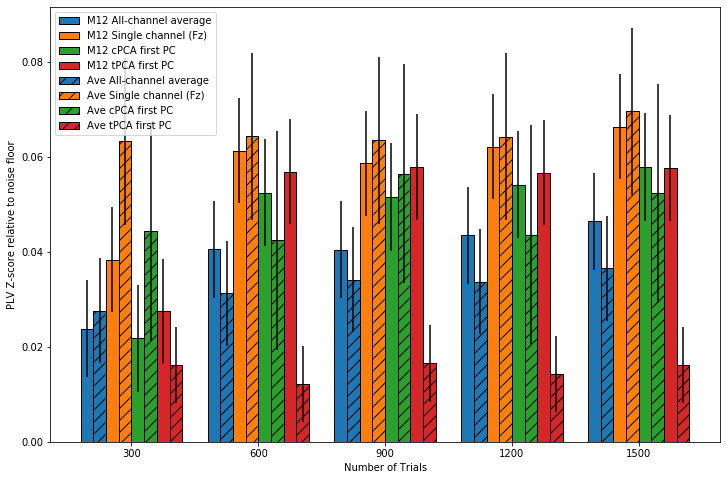

In [50]:
plv_n = np.empty(plv_out.shape[0:4])

for iMethod in range(4):
    for iSize in range(5):
        for iRef in range(2):
            for iSubject in range(15):
                signal = plv_out[iSubject,iRef,iSize,iMethod,index_1]
                noise = plv_out[iSubject,iRef,iSize,iMethod,index_2:index_3]
                plv_n[iSubject,iRef,iSize,iMethod] = (signal-noise.mean())

plt.figure(figsize=(12,8))
         
width = 30    
    
lgd_list=['All-channel average','Single channel (Fz)','cPCA first PC','tPCA first PC']


for i in range(4):
    x_tick=[size+i*width*2-width*4 for size in sample_size]
    plt.bar(x_tick,plv_n[:,0,:,i].mean(0),width,yerr=plv_n[:,0,:,i].std()/np.sqrt(15)
                 ,label='M12 '+ lgd_list[i],color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            edgecolor='black',align='edge')

for i in range(4):
    x_tick=[size+i*width*2-width*3 for size in sample_size]
    plt.bar(x_tick,plv_n[:,1,:,i].mean(0),width,yerr=plv_n[:,1,:,i].std()/np.sqrt(15)
                 ,label='Ave ' + lgd_list[i],color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            hatch='//', edgecolor='black',align='edge')
plt.legend()
plt.xlabel('Number of Trials')
plt.ylabel('PLV Z-score relative to noise floor')
plt.xticks(sample_size)

([<matplotlib.axis.XTick at 0x7f9078710810>,
 <a list of 5 Text xticklabel objects>)

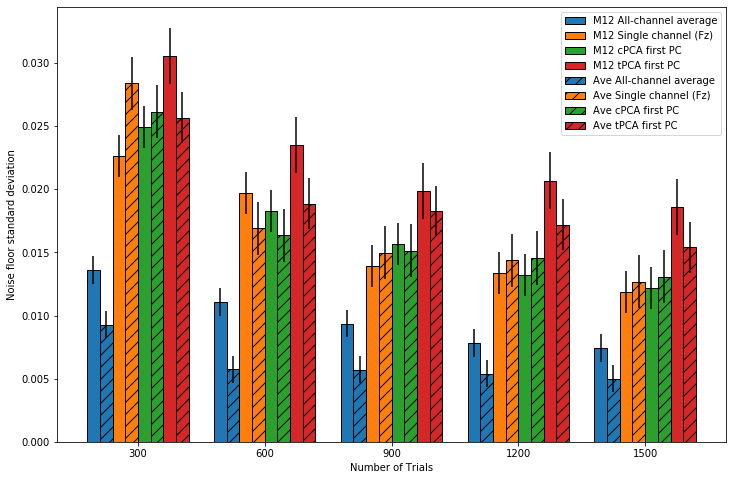

In [49]:
plv_n = np.empty(plv_out.shape[0:4])

for iMethod in range(4):
    for iSize in range(5):
        for iRef in range(2):
            for iSubject in range(15):
                signal = plv_out[iSubject,iRef,iSize,iMethod,index_1]
                noise = plv_out[iSubject,iRef,iSize,iMethod,index_2:index_3]
                plv_n[iSubject,iRef,iSize,iMethod] = noise.std()

plt.figure(figsize=(12,8))
         
width = 30    
    
lgd_list=['All-channel average','Single channel (Fz)','cPCA first PC','tPCA first PC']


for i in range(4):
    x_tick=[size+i*width*2-width*4 for size in sample_size]
    plt.bar(x_tick,plv_n[:,0,:,i].mean(0),width,yerr=plv_n[:,0,:,i].std()/np.sqrt(15)
                 ,label='M12 '+ lgd_list[i],color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            edgecolor='black',align='edge')

for i in range(4):
    x_tick=[size+i*width*2-width*3 for size in sample_size]
    plt.bar(x_tick,plv_n[:,1,:,i].mean(0),width,yerr=plv_n[:,1,:,i].std()/np.sqrt(15)
                 ,label='Ave ' + lgd_list[i],color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            hatch='//', edgecolor='black',align='edge')
plt.legend()
plt.xlabel('Number of Trials')
plt.ylabel('Noise floor standard deviation')
plt.xticks(sample_size)

In [54]:
plv_channels.shape

(15, 2, 5, 63, 224)

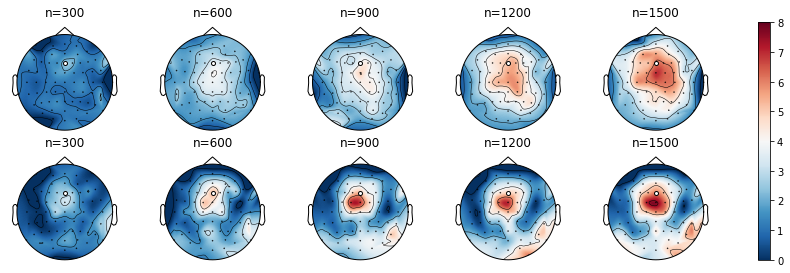

In [46]:
plv_n_channel = np.empty((15,2,5,63))


for iChannel in range(63):
    for iRef in range(2):
        for iSize in range(5):
            for iSubject in range(15):
                signal = plv_channels[iSubject,iRef,iSize,iChannel,index_1]
                noise = plv_channels[iSubject,iRef,iSize,iChannel,index_2:index_3]
                plv_n_channel[iSubject,iRef,iSize,iChannel] = (signal-noise.mean())/noise.std()


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,4))
mask_channel = np.zeros(64,dtype=bool)
mask_channel[37] = True
for iRef in range(2):
    for iSize in range(5):
        im,_=mne.viz.plot_topomap(plv_n_channel[:,iRef,iSize,:].mean(0),pos,axes=axes[iRef,iSize],show=False,
                                  mask=mask_channel[mask_ch],vmin=0,vmax=8,cmap="RdBu_r")
        axes[iRef,iSize].set_title('n='+str(sample_size[iSize]))
fig.colorbar(im,ax=axes)

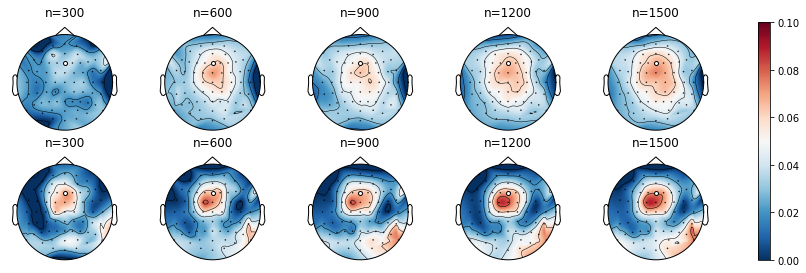

In [47]:
plv_n_channel = np.empty((15,2,5,63))


for iChannel in range(63):
    for iRef in range(2):
        for iSize in range(5):
            for iSubject in range(15):
                signal = plv_channels[iSubject,iRef,iSize,iChannel,index_1]
                noise = plv_channels[iSubject,iRef,iSize,iChannel,index_2:index_3]
                plv_n_channel[iSubject,iRef,iSize,iChannel] = (signal-noise.mean())


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,4))
mask_channel = np.zeros(64,dtype=bool)
mask_channel[37] = True
for iRef in range(2):
    for iSize in range(5):
        im,_=mne.viz.plot_topomap(plv_n_channel[:,iRef,iSize,:].mean(0),pos,axes=axes[iRef,iSize],show=False,
                                  mask=mask_channel[mask_ch],vmin=0,vmax=0.1,cmap="RdBu_r")
        axes[iRef,iSize].set_title('n='+str(sample_size[iSize]))
fig.colorbar(im,ax=axes)

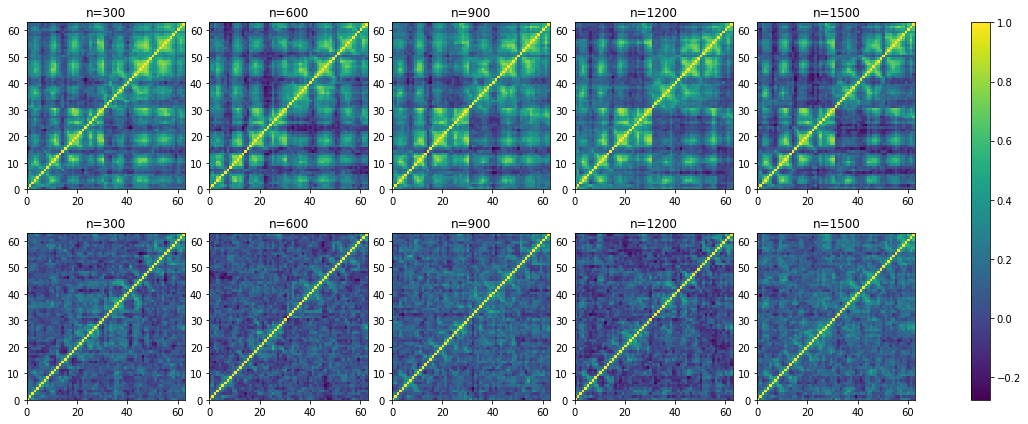

In [82]:
plv_noise_corr = np.empty((15,2,5,63,63))


for iRef in range(2):
    for iSize in range(5):
        for iSubject in range(15):
            noise = plv_channels[iSubject,iRef,iSize,:,index_2:index_3]
            plv_noise_corr[iSubject,iRef,iSize,:,:] = np.corrcoef(noise)
            
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
for iRef in range(2):
    for iSize in range(5):
        pos = axes[iRef,iSize].pcolormesh(plv_noise_corr[:,iRef,iSize,:,:].mean(0))
        axes[iRef,iSize].set_title('n='+str(sample_size[iSize]))

plt.tight_layout()
fig.colorbar(pos,ax=axes)

In [ ]:

for iRef in range(2):
    for iSize in range(5):
        noise = plv_channels[iSubject,iRef,iSize,iChannel,index_2:index_3]
        plv_n_channel[iSubject,iRef,iSize,iChannel] = (signal-noise.mean())


fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
mask_channel = np.zeros(64,dtype=bool)
mask_channel[37] = True
iRef=0
for iSize in range(5):
    im,_=mne.viz.plot_topomap(plv_n_channel[:,iRef,iSize,:].mean(0),pos,axes=axes[iSize],show=False,
                              mask=mask_channel[mask_ch],cmap="RdBu_r")
    axes[iSize].set_title('n='+str(sample_size[iSize]))
fig.colorbar(im,ax=axes)

In [12]:
# load data

folder_path = "./jupyter_projects/MultiChannelSSSR/EEG_data_100_200Hz/"

sample_size = [300,600,900,1200,1500]
plv_out = np.empty((15,2,len(sample_size),4,224))
ID_list = np.arange(2,18)
mask = np.ones(len(ID_list),dtype=bool)
mask[3] = False

plv_channels = np.empty((15,2,len(sample_size),63,224))

Ref_list = ['M12','AVE']


mask_ch = np.ones(64,dtype=bool)
mask_ch[27] = False

for iSubject in range(len(ID_list[mask])):
    print(str(iSubject))
    
    for iRef in range(2):
        
        # read data
        sub_id = 'Sub' + str(ID_list[mask][iSubject])
        mat_contents = loadmat(folder_path + sub_id+'/'+sub_id+'_TMR-5_MSK_HF_'+Ref_list[iRef]
                               +'_Ref_REcleaned.mat')
        ind_list = [sample(range(1500),size) for size in sample_size]
        if iRef==0:
            data = mat_contents['Merged_Data'][mask_ch,103:103+446,:]
        else:
            data = mat_contents['Merged_Data'][:,103:103+446,:]
        nTrial = data.shape[2]

        # FFT
        x=data.transpose(2,0,1)
        xw = np.fft.rfft(np.hamming(x.shape[2])*x, axis=2)
        xw = xw/abs(xw)
        freq = np.fft.rfftfreq(x.shape[2],1/1024)

        for iSize in range(len(sample_size)):
            plv_ave = xw[ind_list[iSize],:,:].mean(0)
            plv_out[iSubject,iRef,iSize,0,:] = abs(plv_ave).mean(0)
            plv_out[iSubject,iRef,iSize,1,:] = abs(plv_ave[37,:])

            plv_channels[iSubject,iRef,iSize,:,:] = abs(plv_ave)

        # cPCA
            plv_mat=np.empty((63,xw.shape[2]),dtype=np.complex64)
            v_mat = []
            for iFreq in range(xw.shape[2]):
                csd = np.matmul(xw[ind_list[iSize],:,iFreq].T,xw[ind_list[iSize],:,iFreq].conj())
                w,v = np.linalg.eig(csd)
                v_mat.append(v)
                pc = np.matmul(v.conj().T,xw[ind_list[iSize],:,iFreq].T)
                plv = (pc/abs(pc)).mean(1)
                plv_mat[:,iFreq] = plv

            plv_out[iSubject,iRef,iSize,2,:] = abs(plv_mat[0,:])

            # concatenate and tPCA
            mix_long = np.concatenate([x[iTrial,:,:] for iTrial in ind_list[iSize]], axis=1)

            pca = decomposition.PCA(n_components=1)
            pca.fit(mix_long.T)
            pc_t = np.empty((len(ind_list[iSize]),446))
            for iTrial in range(len(ind_list[iSize])):
                pc_t[iTrial,:] = pca.transform(x[ind_list[iSize][iTrial],:,:].T).squeeze()
            xw_pc_t = np.fft.rfft(pc_t, axis=1)
            xw_pc_t = xw_pc_t/abs(xw_pc_t)
            plv_pc_t = xw_pc_t.mean(0)

            plv_out[iSubject,iRef,iSize,3,:] = abs(plv_pc_t)

plv_out_HF = plv_out
plv_channels_HF = plv_channels


file_handle = open(folder_path + '/plv_HF.obj','wb')
pickle.dump(plv_out_HF, file_handle)
pickle.dump(plv_channels_HF, file_handle)
file_handle.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [28]:
file_handle = open(folder_path + '/plv_HF.obj','rb')
plv_out = pickle.load(file_handle)
plv_channels = pickle.load(file_handle)
file_handle.close()

In [29]:
index_1 = np.argmin(abs(freq-233.13))
index_2 = np.argmin(abs(freq-180))
index_3 = np.argmin(abs(freq-200))

([<matplotlib.axis.XTick at 0x7f9084705b50>,
 <a list of 5 Text xticklabel objects>)

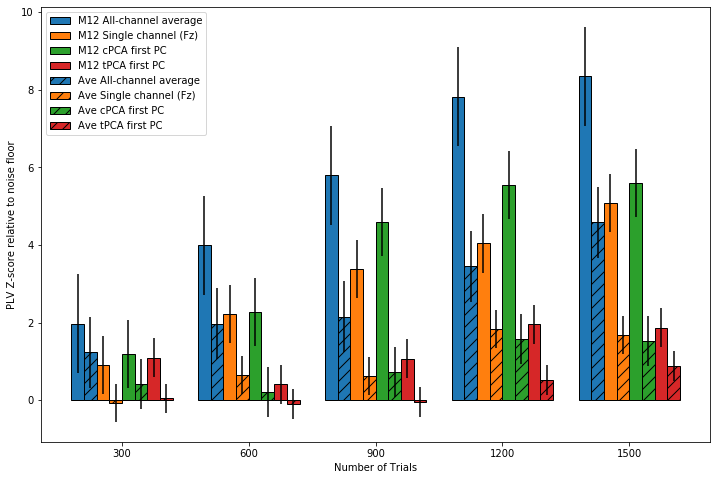

In [16]:
plv_n = np.empty(plv_out.shape[0:4])

for iMethod in range(4):
    for iSize in range(5):
        for iRef in range(2):
            for iSubject in range(15):
                signal = plv_out[iSubject,iRef,iSize,iMethod,index_1]
                noise = plv_out[iSubject,iRef,iSize,iMethod,index_2:index_3]
                plv_n[iSubject,iRef,iSize,iMethod] = (signal-noise.mean())/noise.std()

plt.figure(figsize=(12,8))
         
width = 30    
    
lgd_list=['All-channel average','Single channel (Fz)','cPCA first PC','tPCA first PC']


for i in range(4):
    x_tick=[size+i*width*2-width*4 for size in sample_size]
    plt.bar(x_tick,plv_n[:,0,:,i].mean(0),width,yerr=plv_n[:,0,:,i].std()/np.sqrt(15)
                 ,label='M12 '+ lgd_list[i],color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            edgecolor='black',align='edge')

for i in range(4):
    x_tick=[size+i*width*2-width*3 for size in sample_size]
    plt.bar(x_tick,plv_n[:,1,:,i].mean(0),width,yerr=plv_n[:,1,:,i].std()/np.sqrt(15)
                 ,label='Ave ' + lgd_list[i],color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            hatch='//', edgecolor='black',align='edge')
plt.legend(loc='upper left')
plt.xlabel('Number of Trials')
plt.ylabel('PLV Z-score relative to noise floor')
plt.xticks(sample_size)

([<matplotlib.axis.XTick at 0x7f908455af90>,
 <a list of 5 Text xticklabel objects>)

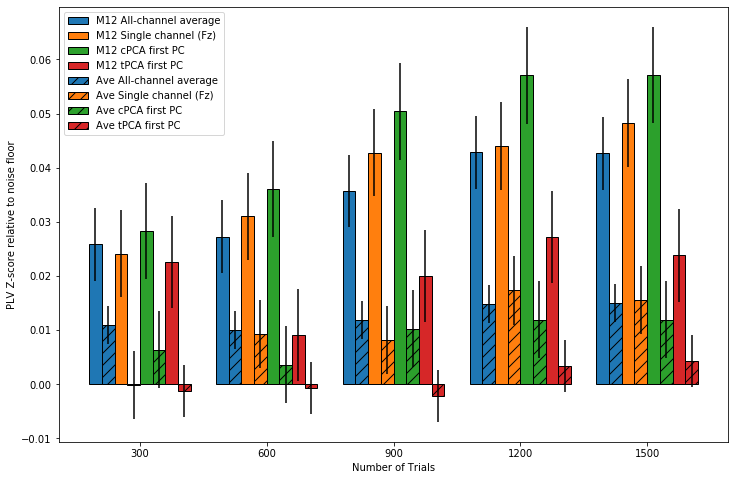

In [18]:
plv_n = np.empty(plv_out.shape[0:4])

for iMethod in range(4):
    for iSize in range(5):
        for iRef in range(2):
            for iSubject in range(15):
                signal = plv_out[iSubject,iRef,iSize,iMethod,index_1]
                noise = plv_out[iSubject,iRef,iSize,iMethod,index_2:index_3]
                plv_n[iSubject,iRef,iSize,iMethod] = (signal-noise.mean())

plt.figure(figsize=(12,8))
         
width = 30    
    
lgd_list=['All-channel average','Single channel (Fz)','cPCA first PC','tPCA first PC']


for i in range(4):
    x_tick=[size+i*width*2-width*4 for size in sample_size]
    plt.bar(x_tick,plv_n[:,0,:,i].mean(0),width,yerr=plv_n[:,0,:,i].std()/np.sqrt(15)
                 ,label='M12 '+ lgd_list[i],color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            edgecolor='black',align='edge')

for i in range(4):
    x_tick=[size+i*width*2-width*3 for size in sample_size]
    plt.bar(x_tick,plv_n[:,1,:,i].mean(0),width,yerr=plv_n[:,1,:,i].std()/np.sqrt(15)
                 ,label='Ave ' + lgd_list[i],color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            hatch='//', edgecolor='black',align='edge')
plt.legend(loc='upper left')
plt.xlabel('Number of Trials')
plt.ylabel('PLV Z-score relative to noise floor')
plt.xticks(sample_size)

([<matplotlib.axis.XTick at 0x7f9084229ad0>,
 <a list of 5 Text xticklabel objects>)

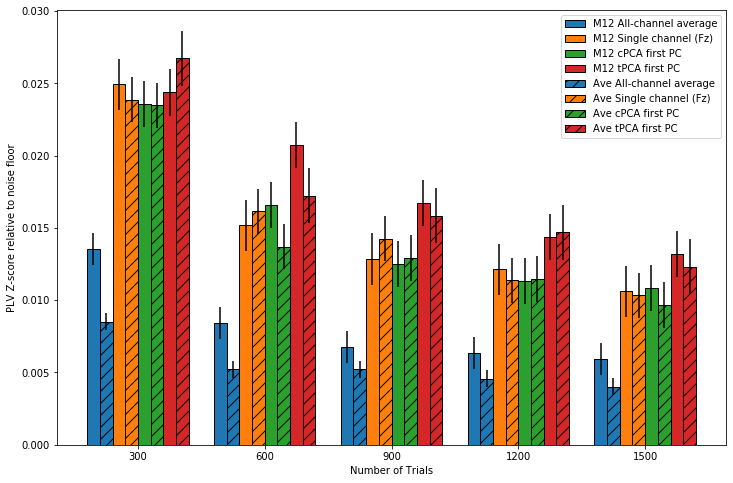

In [21]:
plv_n = np.empty(plv_out.shape[0:4])

for iMethod in range(4):
    for iSize in range(5):
        for iRef in range(2):
            for iSubject in range(15):
                signal = plv_out[iSubject,iRef,iSize,iMethod,index_1]
                noise = plv_out[iSubject,iRef,iSize,iMethod,index_2:index_3]
                plv_n[iSubject,iRef,iSize,iMethod] = noise.std()

plt.figure(figsize=(12,8))
         
width = 30    
    
lgd_list=['All-channel average','Single channel (Fz)','cPCA first PC','tPCA first PC']


for i in range(4):
    x_tick=[size+i*width*2-width*4 for size in sample_size]
    plt.bar(x_tick,plv_n[:,0,:,i].mean(0),width,yerr=plv_n[:,0,:,i].std()/np.sqrt(15)
                 ,label='M12 '+ lgd_list[i],color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            edgecolor='black',align='edge')

for i in range(4):
    x_tick=[size+i*width*2-width*3 for size in sample_size]
    plt.bar(x_tick,plv_n[:,1,:,i].mean(0),width,yerr=plv_n[:,1,:,i].std()/np.sqrt(15)
                 ,label='Ave ' + lgd_list[i],color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            hatch='//', edgecolor='black',align='edge')
plt.legend()
plt.xlabel('Number of Trials')
plt.ylabel('PLV Z-score relative to noise floor')
plt.xticks(sample_size)

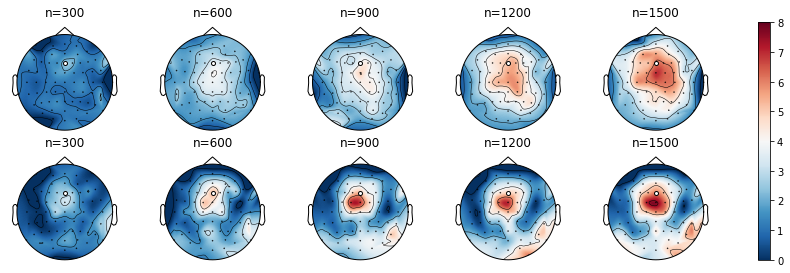

In [48]:
plv_n_channel = np.empty((15,2,5,63))


for iChannel in range(63):
    for iRef in range(2):
        for iSize in range(5):
            for iSubject in range(15):
                signal = plv_channels[iSubject,iRef,iSize,iChannel,index_1]
                noise = plv_channels[iSubject,iRef,iSize,iChannel,index_2:index_3]
                plv_n_channel[iSubject,iRef,iSize,iChannel] = (signal-noise.mean())/noise.std()


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,4))
mask_channel = np.zeros(64,dtype=bool)
mask_channel[37] = True
for iRef in range(2):
    for iSize in range(5):
        im,_=mne.viz.plot_topomap(plv_n_channel[:,iRef,iSize,:].mean(0),pos,axes=axes[iRef,iSize],show=False,
                                  mask=mask_channel[mask_ch],vmin=0,vmax=8,cmap="RdBu_r")
        axes[iRef,iSize].set_title('n='+str(sample_size[iSize]))
fig.colorbar(im,ax=axes)

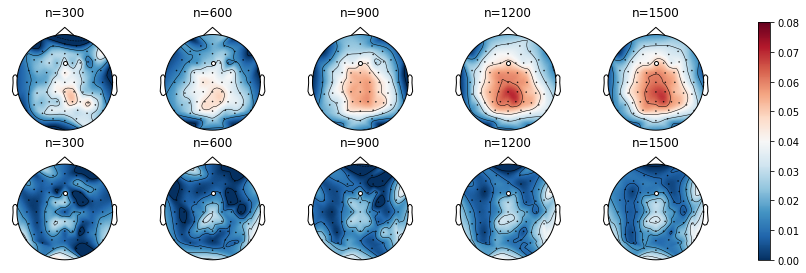

In [43]:
plv_n_channel = np.empty((15,2,5,63))


for iChannel in range(63):
    for iRef in range(2):
        for iSize in range(5):
            for iSubject in range(15):
                signal = plv_channels[iSubject,iRef,iSize,iChannel,index_1]
                noise = plv_channels[iSubject,iRef,iSize,iChannel,index_2:index_3]
                plv_n_channel[iSubject,iRef,iSize,iChannel] = (signal-noise.mean())


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,4))
mask_channel = np.zeros(64,dtype=bool)
mask_channel[37] = True
for iRef in range(2):
    for iSize in range(5):
        im,_=mne.viz.plot_topomap(plv_n_channel[:,iRef,iSize,:].mean(0),pos,axes=axes[iRef,iSize],show=False,
                                  mask=mask_channel[mask_ch],vmin=0,vmax=0.08,cmap="RdBu_r")
        axes[iRef,iSize].set_title('n='+str(sample_size[iSize]))
fig.colorbar(im,ax=axes)

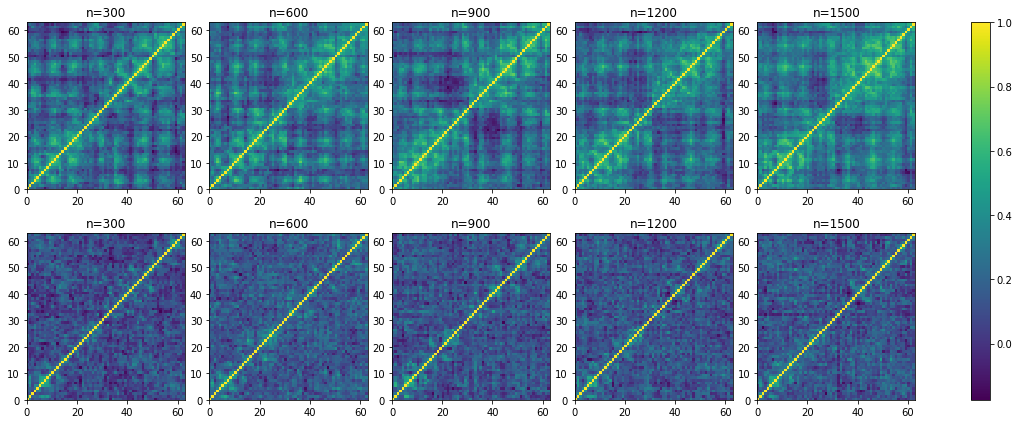

In [36]:
plv_noise_corr = np.empty((15,2,5,63,63))


for iRef in range(2):
    for iSize in range(5):
        for iSubject in range(15):
            noise = plv_channels[iSubject,iRef,iSize,:,index_2:index_3]
            plv_noise_corr[iSubject,iRef,iSize,:,:] = np.corrcoef(noise)
            
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
for iRef in range(2):
    for iSize in range(5):
        pos = axes[iRef,iSize].pcolormesh(plv_noise_corr[:,iRef,iSize,:,:].mean(0))
        axes[iRef,iSize].set_title('n='+str(sample_size[iSize]))

plt.tight_layout()
fig.colorbar(pos,ax=axes)